In [1]:
from providers.generic_provider import GenericProvider
from database.chroma_db import ChromaDBManager


/Users/lilianahotsko/Desktop/LLMAnonymizationThesis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Helper Functions

In [35]:
def build_question_prompt(chunk):
    return f"""
Ти — AI-асистент, який допомагає створювати синтетичні запитання для набору даних.

На основі наведеного нижче контексту згенеруйте чітке та таке запитання, на яке можна відповісти, використовуючи лише цей контекст.

Контекст:
\"\"\"
{chunk}
\"\"\"

Запитання:"""


async def generate_questions(stored_chunks, llm_question_generator, db:ChromaDBManager):
    questions = []
    all_retrieved_chunks = []
    for chunk in stored_chunks:
        prompt = build_question_prompt(chunk)
        question = await llm_question_generator.invoke(prompt)
        questions.append(question.strip())
        retrieved_chunks = db.retrieve(question, 5)
        all_retrieved_chunks.append(retrieved_chunks)
    return questions, all_retrieved_chunks


async def generate_question(chunk, llm_question_generator):
    prompt = build_question_prompt(chunk)
    question = await llm_question_generator.invoke(prompt)
    return question.strip()

async def generate_ground_truth_responses(questions, retrieved_chunks, reference_llm_provider):
    ground_truth_responses = []
    for i in range(len(questions)):
        context = "\n".join(retrieved_chunks[i])
        prompt = f"Answer the question based on the following context:\n\n{context}\n\nQuestion: {questions[i]}"
        response = await reference_llm_provider.invoke(prompt)
        ground_truth_responses.append(response)
    return ground_truth_responses

async def run_reference_query(query, context_chunks, llm_provider):
    context = "\n".join(context_chunks)
    prompt = f"Answer the question based on the following context:\n\n{context}\n\nQuestion: {query}"
    return await llm_provider.invoke(prompt), context_chunks

async def run_test_query(query, context_chunks, test_llm_provider):
    context = "\n".join(context_chunks)
    prompt = f"Answer the question based on the following context:\n\n{context}\n\nQuestion: {query}"
    return await test_llm_provider.invoke(prompt), context_chunks


from datasets import Dataset

async def create_ragas_dataset(questions,
                        retrieved_chunks,
                        ground_truth_responses,
                        test_llm_provider):

    answers = []
    contexts = []

    for i in range(len(questions)):
        test_answer, test_context_chunks = await run_test_query(questions[i], retrieved_chunks[i], test_llm_provider)
        answers.append(test_answer)
        contexts.append(test_context_chunks)

    ragas_data = Dataset.from_dict({
        "question": questions,
        "answer": answers,
        "contexts": retrieved_chunks,
        "reference": ground_truth_responses
    })

    return ragas_data


async def create_ragas_dataset_with_final_answer(questions,
                        retrieved_chunks,
                        ground_truth_responses,
                        final_responses):

    ragas_data = Dataset.from_dict({
        "question": questions,
        "answer": final_responses,
        "contexts": retrieved_chunks,
        "reference": ground_truth_responses
    })

    return ragas_data

from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
)

def evaluate_rag(ragas_data):
    result = evaluate(
        dataset=ragas_data,
        metrics=[
            faithfulness,
            answer_relevancy,
            context_precision,
            context_recall,
            answer_correctness
        ]
    )
    return result



In [17]:
# Test setup

llm_question_generator = GenericProvider({
    "provider":"openai",
    "model": "gpt-4o",
    "temperature": 0,
    "max_tokens": 512
})

reference_llm_provider = GenericProvider({
    "provider":"openai",
    "model": "gpt-4o",
    "temperature": 0,
    "max_tokens": 512
})

test_llm_provider = GenericProvider({
    "provider":"openai",
    "model": "gpt-4o",
    "temperature": 0,
    "max_tokens": 512
})

In [33]:

folder_name="uploaded_files/ukrainian_fairy_tail"
collection_name="rag_collection_uk_rag_test"
persist_path = "./vectorstore_uk/test_data_rag"

chroma_db = ChromaDBManager(
        collection_name=collection_name,
        persist_path=persist_path,
        chunk_size=300,
        chunk_overlap=150,
        model_name="all-MiniLM-L6-v2", 
        reset=True
    )

chroma_db.store_file(folder_name)
stored_chunks = chroma_db.get_stored_chunks()
questions, retrieved_chunks = await generate_questions(stored_chunks[:40], llm_question_generator, chroma_db)
ground_truth_responses = await generate_ground_truth_responses(questions, retrieved_chunks, reference_llm_provider)

ragas_data = await create_ragas_dataset(questions,
                                        retrieved_chunks,
                                        ground_truth_responses,
                                        test_llm_provider)
result = evaluate_rag(ragas_data)
pd_results = result.to_pandas()
pd_results.head()

Existing collections: ['rag_collection_uk_rag_test']
Collection 'rag_collection_uk_rag_test' deleted.
Collection 'rag_collection_uk_rag_test' has been reset.
МІСТО Роман Шість прикмет має людина: трьома подібна вона на тварину, а трьома на янгола: як тварина — людина їсть і п’є: як тварина — вона множиться і як тварина — викидає; як янгол — вона має розум, як янгол — ходить просто і як янгол — священною мовою розмовляє. Талмуд. Трактат Авот Як можна бути вільним, Евкріте, коли маєш тіло? А. Франс. Таїс ЧАСТИНА ПЕРША І Здавалось, далі пливти нема куди. Спереду Дніпро мов спинився в несподіваній затоці, оточений праворуч, ліворуч і просто зелено-жовтими передосінніми берегами. Але пароплав раптом звернув, і довга, спокійна смуга річки протяглася далі до ледве помітних пагорків на обрії. Степан стояв коло поруччя на палубі, мимоволі пірнаючи очима в ту далечінь, і мірні удари лопастей пароплавного колеса, глухі капітанові слова коло рупора відбирали снагу в його думок. Вони теж спинялись 

Evaluating: 100%|██████████| 120/120 [01:31<00:00,  1.31it/s]


,user_input,retrieved_contexts,response,reference,faithfulness,context_recall,answer_correctness
0,Якими рисами людина подібна на тварину та яким...,"[Ну, а мова латинська, хіба вона кому потрібна...",У трактаті Авот (Піркей Авот) Талмуду згадуєть...,"Згідно з Талмудом у трактаті Авот, людина поді...",0.000000,0.75,0.731820
1,Які характеристики янгола згадуються в контексті?,"[Ну, а мова латинська, хіба вона кому потрібна...",У наданому контексті не згадуються характерист...,У наданому контексті не згадуються жодні харак...,1.000000,1.00,0.378777
2,"Куди звернув пароплав, коли здавалося, що далі...","[Ну, а мова латинська, хіба вона кому потрібна...",У наведеному контексті немає інформації про ку...,У наданому контексті відсутня інформація про т...,0.750000,1.00,0.427673
3,"Що Степан робив на палубі пароплава, коли він ...",[побороти в місті. Наперекір розумові й усім п...,"Степан стояв коло поруччя на палубі пароплава,...","Степан стояв коло поруччя на палубі пароплава,...",1.000000,1.00,0.698597
4,"Що робив Степан на палубі, коли дивився в дале...","[Ну, а мова латинська, хіба вона кому потрібна...",У наведеному вами уривку немає інформації про ...,У наданому контексті немає конкретної згадки п...,0.666667,0.00,0.453669


In [34]:
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

Average values for each metric:
faithfulness          0.649177
context_recall        0.805000
answer_correctness    0.616333
dtype: float64


# Anonymization Pipelines

In [36]:
columns = ["question", "collection_name", "retrieved_chunks", "ground_truth", "time_taken_ground_truth", "test_response", "test_resulting_metrics", "time_taken_test"]
experiment_columns = ["_masked_prompt","_response", "_resulting_metrics", "_time_taken"]

In [55]:
folder_name="uploaded_files/ukrainian_fairy_tail"
collection_name="base_collection"
persist_path = "./vectorstore_uk/test_data_rag"

reference_llm_provider = GenericProvider({
    "provider":"openai",
    "model": "gpt-4o",
    "temperature": 0.3,
    "max_tokens": 512
})


chroma_db = ChromaDBManager(
        collection_name=collection_name,
        persist_path=persist_path,
        chunk_size=300,
        chunk_overlap=150,
        model_name="all-MiniLM-L6-v2", 
        reset=True
    )

chroma_db.store_file(folder_name)
stored_chunks = chroma_db.get_stored_chunks()
questions, retrieved_chunks = await generate_questions(stored_chunks[:100], llm_question_generator, chroma_db)

ground_truth_responses = await generate_ground_truth_responses(questions, retrieved_chunks, reference_llm_provider)

ragas_data = await create_ragas_dataset(questions,
                                        retrieved_chunks,
                                        ground_truth_responses,
                                        test_llm_provider)
result = evaluate_rag(ragas_data)
pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

import pandas as pd

data = {
    "question": questions,
    "retrieved_chunks": retrieved_chunks,
    "ground_truth": ground_truth_responses,
    "ground_faithfulness" : pd_results["faithfulness"],
    "ground_answer_relevancy":pd_results["answer_relevancy"],
    "ground_context_precision":pd_results["context_precision"],
    "ground_context_recall" :pd_results["context_recall"],
    "ground_answer_correctness":pd_results["answer_correctness"]
}

df = pd.DataFrame(data)
csv_file_path = "./test_results_uk/references_data.csv"
df.to_csv(csv_file_path, index=False)

Existing collections: ['base_collection', 'rag_collection_uk_rag_test']
Collection 'base_collection' deleted.
Collection 'base_collection' has been reset.
МІСТО Роман Шість прикмет має людина: трьома подібна вона на тварину, а трьома на янгола: як тварина — людина їсть і п’є: як тварина — вона множиться і як тварина — викидає; як янгол — вона має розум, як янгол — ходить просто і як янгол — священною мовою розмовляє. Талмуд. Трактат Авот Як можна бути вільним, Евкріте, коли маєш тіло? А. Франс. Таїс ЧАСТИНА ПЕРША І Здавалось, далі пливти нема куди. Спереду Дніпро мов спинився в несподіваній затоці, оточений праворуч, ліворуч і просто зелено-жовтими передосінніми берегами. Але пароплав раптом звернув, і довга, спокійна смуга річки протяглася далі до ледве помітних пагорків на обрії. Степан стояв коло поруччя на палубі, мимоволі пірнаючи очима в ту далечінь, і мірні удари лопастей пароплавного колеса, глухі капітанові слова коло рупора відбирали снагу в його думок. Вони теж спинялись у т

Evaluating: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]


Average values for each metric:
faithfulness          0.725016
answer_relevancy      0.379277
context_precision     0.280875
context_recall        0.786357
answer_correctness    0.616433
dtype: float64


In [51]:
c = 0
for i in ground_truth_responses:
    print(c, i)
    c+=1

0 В наведеному контексті немає чіткої відповіді на питання, які три ознаки роблять людину подібною на тварину. Це питання, ймовірно, відноситься до іншого контексту або тексту. В наведеному тексті розповідається про Степана, його відчуття та спостереження, але нема згадки про порівняння людей з тваринами.
1 У наведеному контексті людина описується як зосереджена, дещо млява та змушена жити в умовах, що викликають у неї зневагу і роздратування. Вона відчуває себе приниженою, проживаючи неналежним чином, що викликає в ній сильні емоційні переживання. Водночас ця людина має досвід складного та різноманітного життя, була підпасичем-приймаком, повстанцем, і зараз змушена порівнювати своє життя з життям тварин у хліві. Спустошена і пригнічена, вона спостерігає за навколишнім світом без особливого інтересу.
2 На жаль, наданий контекст не містить інформації про враження від Дніпра перед тим, як пароплав зробив поворот. Текст зосереджений на інших сценах і внутрішніх міркуваннях персонажа Степа

In [50]:
# Select the specific columns
df1 = df
columns_to_average = ["ground_answer_relevancy"]

# Calculate row-wise average and save it as a new column
df1["average_score"] = df1[columns_to_average].mean(axis=1)

# Display
print(df1[["question", "average_score"]])


                                            question  average_score
0  Якими трьома ознаками людина подібна на тварин...       0.000000
1       Як описується людина в наведеному контексті?       1.000000
2  Яке враження складається про Дніпро перед тим,...       0.000000
3  Який пейзаж спостерігає Степан, стоячи коло по...       0.869687
4  Куди спрямовані думки Степана, коли він стоїть...       0.000000
5  Що з'явилося на повороті праворуч, коли хлопец...       0.941388
6  Яке враження справляє серпневе сонце на село, ...       0.000000
7  Який образ створює серпневе сонце у цьому конт...       0.000000
8  Як третій шлях взаємодіяв із селом у наведеном...       0.975610
9  Що було спільного між селом, де спав герой, і ...       0.000000


In [52]:
num_rows = (df["ground_answer_relevancy"] < 0.7).sum()
print(f"Number of rows where ground_answer_relevancy < 0.7: {num_rows}")


Number of rows where ground_answer_relevancy < 0.7: 6


In [56]:
filtered_rows = df[df["ground_answer_relevancy"] > 0.7]

for idx, row in filtered_rows.iterrows():
    print(f"Question: {row['question']}")
    print(f"Retrieved Chunks: {row['retrieved_chunks']}")
    print(f"Ground Truth: {row['ground_truth']}")
    print(f"Answer Relevancy: {row['ground_answer_relevancy']:.2f}")
    print("-" * 60)


Question: Що робив Степан, стоячи на палубі пароплава?
Retrieved Chunks: ['сніданку, але вона зайшла в його кабінет, глянула на його речі й поставила долі відро з молоком. — Твердо було спати?\xa0— сумно, якось стомлено спитала вона, помацавши рукою верстат. — Н-да,— невдоволено пробурчав Степан. Все-таки вона не йшла. Що їй, власне, треба? Що це за оглядини такі пильні й', 'управи. Степан переступив поріг, трохи побоюючись, чи не побачить надто чуже обличчя в кріслі коло столу, м’які меблі й застелену килимом підлогу. Це ж як-не-як, а в Києві! Але заспокоївся з першого погляду. Обстава в кабінеті голови управи мало чим різнилась від умеблювання кімнати райбюро, що', 'сірників і, хоч як йому хотілось закурити, боявся, щоб не знудило. Він передусім скупається, потім перекусить, а вже потім можна буде поласувати цигаркою. Проте скупатись йому не пощастило\xa0— це можна було робити тільки на пляжі, тобто перевізшись з берега на острів. Це коштувало п’ять копійок', 'не гірше, ніж у людей. 

In [57]:
len(filtered_rows)

41

In [59]:
filtered_questions = filtered_rows["question"].tolist()
filtered_retrieved_chunks = filtered_rows["retrieved_chunks"].tolist()
filtered_ground_truth_responses = filtered_rows["ground_truth"].tolist()

filtered_ragas_data = await create_ragas_dataset(
    filtered_questions,
    filtered_retrieved_chunks,
    filtered_ground_truth_responses,
    test_llm_provider 
)

filtered_result = evaluate_rag(filtered_ragas_data)
print(filtered_result)

Evaluating: 100%|██████████| 205/205 [02:01<00:00,  1.69it/s]


{'faithfulness': 0.6923, 'answer_relevancy': 0.7691, 'context_precision': 0.5183, 'context_recall': 0.8423, 'answer_correctness': 0.6849}


In [68]:
import pandas as pd

filtered_data = {
    "question": filtered_questions,
    "retrieved_chunks": filtered_retrieved_chunks,
    "ground_truth": filtered_ground_truth_responses,
    "ground_faithfulness": filtered_result["faithfulness"],
    "ground_answer_relevancy": filtered_result["answer_relevancy"],
    "ground_context_precision": filtered_result["context_precision"],
    "ground_context_recall": filtered_result["context_recall"],
    "ground_answer_correctness": filtered_result["answer_correctness"],
}

filtered_df = pd.DataFrame(filtered_data)

csv_file_path = "./test_results_uk/references_data.csv"
filtered_df.to_csv(csv_file_path, index=False)

print(f"Saved filtered evaluation results to {csv_file_path}")


Saved filtered evaluation results to ./test_results_uk/references_data.csv


In [71]:
import pandas as pd
reference_data = pd.read_csv("./test_results_uk/references_data.csv")


In [ ]:
questions = reference_data["question"]
retrieved_chunks = reference_data["retrieved_chunks"]
reference_answer = reference_data["ground_truth"]


---

## Test on LLaMA

In [82]:

test_llm_provider = GenericProvider({
    "provider":"llama",
    "model": "llama3.2",
    "temperature": 0,
    "max_tokens": 512
})

ragas_data = await create_ragas_dataset(questions[:30],
                                        retrieved_chunks[:30],
                                        reference_answer[:30],
                                        test_llm_provider)

import ast

ragas_data2 = ragas_data.map(lambda example: 
                            {'contexts': ast.literal_eval(example['contexts'])}, 
                            num_proc=4) 

result = evaluate_rag(ragas_data2)
pd_results = result.to_pandas()


Evaluating: 100%|██████████| 150/150 [01:16<00:00,  1.97it/s]


In [83]:
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

Average values for each metric:
faithfulness          0.027778
answer_relevancy      0.365239
context_precision     0.588472
context_recall        0.802778
answer_correctness    0.280784
dtype: float64


In [84]:
test_result_data = {
    "test_answer" : ragas_data["answer"],
    "test_faithfulness" : pd_results["faithfulness"],
    "test_answer_relevancy":pd_results["answer_relevancy"],
    "test_context_precision":pd_results["context_precision"],
    "test_context_recall" :pd_results["context_recall"],
    "test_answer_correctness":pd_results["answer_correctness"]
}

test_result_data_df = pd.DataFrame(test_result_data)
test_result_data_df = pd.concat([reference_data, test_result_data_df], ignore_index=True)
csv_file_path = "./test_results_uk/llama_data.csv"
test_result_data_df.to_csv(csv_file_path, index=False)

In [196]:
metric_averages = llama_df.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

Average values for each metric:
ground_faithfulness          0.692276
ground_answer_relevancy      0.769059
ground_context_precision     0.518293
ground_context_recall        0.842334
ground_answer_correctness    0.684875
test_faithfulness            0.027778
test_answer_relevancy        0.365239
test_context_precision       0.588472
test_context_recall          0.802778
test_answer_correctness      0.280784
dtype: float64


---
## Test on Mistral

In [85]:
test_llm_provider = GenericProvider({
    "provider":"mistral",
    "model": "mistral",
    "temperature": 0,
    "max_tokens": 512
})

ragas_data = await create_ragas_dataset(questions,
                                        retrieved_chunks,
                                        reference_answer,
                                        test_llm_provider)

import ast

ragas_data2 = ragas_data.map(lambda example: 
                            {'contexts': ast.literal_eval(example['contexts'])}, 
                            num_proc=4) 

result = evaluate_rag(ragas_data2)

pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()


test_result_data = {
    "test_answer" : ragas_data["answer"],
    "test_faithfulness" : pd_results["faithfulness"],
    "test_answer_relevancy":pd_results["answer_relevancy"],
    "test_context_precision":pd_results["context_precision"],
    "test_context_recall" :pd_results["context_recall"],
    "test_answer_correctness":pd_results["answer_correctness"]
}

test_result_data_df = pd.DataFrame(test_result_data)
test_result_data_df = pd.concat([reference_data, test_result_data_df], ignore_index=True)
csv_file_path = "./test_results_uk/mistral_data.csv"
test_result_data_df.to_csv(csv_file_path, index=False)

Evaluating: 100%|██████████| 205/205 [02:41<00:00,  1.27it/s]


In [86]:
print("Average values for each metric:")
print(metric_averages)

Average values for each metric:
faithfulness          0.224990
answer_relevancy      0.554452
context_precision     0.537466
context_recall        0.851161
answer_correctness    0.313444
dtype: float64


---
## NER + OPENAI

In [89]:
from privacy_pipeline import PrivacyPipeline
final_outputs = []
privacy_pipeline = PrivacyPipeline("./test_configs_ukr/ukr_ner1_config.yml")

for i in range(len(questions)):
    question, chunks, ref_answer = questions[i], retrieved_chunks[i], reference_answer[i]
    result = await privacy_pipeline.process_pipeline(chunks, question)
    pipeline_final_output = result["final_output"]
    final_outputs.append(pipeline_final_output)

PATTERN PROCESSOR
{}
{}
NER PROCESSOR
{'Степан': '[PER_0]', 'Києві': '[LOC_1]'}
{'[PER_0]': 'Степан', '[LOC_1]': 'Києві'}
LLM INVOKE
{'Степан': '[PER_0]', 'Києві': '[LOC_1]'}
Що робив [PER_0], стоячи на палубі пароплава?
Завдання: Що робив [PER_0], стоячи на палубі пароплава?

Текст: ['сніданку, але вона зайшла в його кабінет, глянула на його речі й поставила долі відро з молоком. — Твердо було спати?\xa0— сумно, якось стомлено спитала вона, помацавши рукою верстат. — Н-да,— невдоволено пробурчав [PER_0]. Все-таки вона не йшла. Що їй, власне, треба? Що це за оглядини такі пильні й', 'управи. [PER_0] переступив поріг, трохи побоюючись, чи не побачить надто чуже обличчя в кріслі коло столу, м’які меблі й застелену килимом підлогу. Це ж як-не-як, а в [LOC_1]! Але заспокоївся з першого погляду. Обстава в кабінеті голови управи мало чим різнилась від умеблювання кімнати райбюро, що', 'сірників і, хоч як йому хотілось закурити, боявся, щоб не знудило. Він передусім скупається, потім перекуси

In [90]:
import ast

ragas_data = await create_ragas_dataset_with_final_answer(questions,
                                       retrieved_chunks, 
                                       reference_answer,
                                       final_outputs)

ragas_data2 = ragas_data.map(lambda example: 
                            {'contexts': ast.literal_eval(example['contexts'])}, 
                            num_proc=4) 

result = evaluate_rag(ragas_data2)

Evaluating: 100%|██████████| 205/205 [02:00<00:00,  1.71it/s]


In [91]:
pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

test_result_data = {
    "test_answer" : ragas_data["answer"],
    "test_faithfulness" : pd_results["faithfulness"],
    "test_answer_relevancy":pd_results["answer_relevancy"],
    "test_context_precision":pd_results["context_precision"],
    "test_context_recall" :pd_results["context_recall"],
    "test_answer_correctness":pd_results["answer_correctness"]
}

test_result_data_df = pd.DataFrame(test_result_data)
test_result_data_df = pd.concat([reference_data, test_result_data_df], ignore_index=True)
csv_file_path = "./test_results/openai1_data.csv"
test_result_data_df.to_csv(csv_file_path, index=False)

Average values for each metric:
faithfulness          0.670160
answer_relevancy      0.670444
context_precision     0.524051
context_recall        0.835656
answer_correctness    0.588999
dtype: float64


---
## Context-aware -1 

In [109]:
final_outputs_context = []
privacy_pipeline = PrivacyPipeline("./test_configs_ukr/ukr_spacy_context1.yml")

for i in range(len(questions)):
    question, chunks, ref_answer = questions[i], retrieved_chunks[i], reference_answer[i]
    result = await privacy_pipeline.process_pipeline(chunks, question)
    pipeline_final_output = result["final_output"]
    final_outputs_context.append(pipeline_final_output)

PATTERN PROCESSOR
{}
{}
NER PROCESSOR
{'Степан': '[PER_0]', 'Києві': '[LOC_1]'}
{'[PER_0]': 'Степан', '[LOC_1]': 'Києві'}
CONTEXT MASKER
['сніданку, але вона зайшла в його кабінет, глянула на його речі й поставила долі відро з молоком. — Твердо було спати?\xa0— сумно, якось стомлено спитала вона, помацавши рукою верстат. — Н-да,— невдоволено пробурчав Иван. Все-таки вона не йшла. Що їй, власне, треба? Що це за оглядини такі пильні й', 'управи. Иван переступив поріг, трохи побоюючись, чи не побачить надто чуже обличчя в кріслі коло столу, м’які меблі й застелену килимом підлогу. Це ж як-не-як, а в Minsk! Але заспокоївся з першого погляду. Обстава в кабінеті голови управи мало чим різнилась від умеблювання кімнати райбюро, що', 'сірників і, хоч як йому хотілось закурити, боявся, щоб не знудило. Він передусім скупається, потім перекусить, а вже потім можна буде поласувати цигаркою. Проте скупатись йому не пощастило\xa0— це можна було робити тільки на пляжі, тобто перевізшись з берега на о

In [110]:
import ast

ragas_data = await create_ragas_dataset_with_final_answer(questions,
                                       retrieved_chunks, 
                                       reference_answer,
                                       final_outputs_context)

ragas_data2 = ragas_data.map(lambda example: 
                            {'contexts': ast.literal_eval(example['contexts'])}, 
                            num_proc=4) 

result = evaluate_rag(ragas_data2)


Evaluating: 100%|██████████| 205/205 [01:58<00:00,  1.73it/s]


In [112]:
pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

test_result_data = {
    "test_answer" : ragas_data["answer"],
    "test_faithfulness" : pd_results["faithfulness"],
    "test_answer_relevancy":pd_results["answer_relevancy"],
    "test_context_precision":pd_results["context_precision"],
    "test_context_recall" :pd_results["context_recall"],
    "test_answer_correctness":pd_results["answer_correctness"]
}

test_result_data_df = pd.DataFrame(test_result_data)
test_result_data_df = pd.concat([reference_data, test_result_data_df], ignore_index=True)
csv_file_path = "./test_results_uk/spacy_data_context_1.csv"
test_result_data_df.to_csv(csv_file_path, index=False)

Average values for each metric:
faithfulness          0.724197
answer_relevancy      0.511153
context_precision     0.536247
context_recall        0.819977
answer_correctness    0.570333
dtype: float64


---
# Context-aware -2

In [114]:
final_outputs_context = []
privacy_pipeline = PrivacyPipeline("./test_configs_ukr/ukr_spacy_context2.yml")

for i in range(len(questions)):
    question, chunks, ref_answer = questions[i], retrieved_chunks[i], reference_answer[i]
    result = await privacy_pipeline.process_pipeline(chunks, question)
    pipeline_final_output = result["final_output"]
    final_outputs_context.append(pipeline_final_output)

PATTERN PROCESSOR
{}
{}
NER PROCESSOR
{'Степан': '[PER_0]', 'Києві': '[LOC_1]'}
{'[PER_0]': 'Степан', '[LOC_1]': 'Києві'}
CONTEXT MASKER
['сніданку, але вона зайшла в його кабінет, глянула на його речі й поставила долі відро з молоком. — Твердо було спати?\xa0— сумно, якось стомлено спитала вона, помацавши рукою верстат. — Н-да,— невдоволено пробурчав Stepan was replaced with a fictional character from the same category: "Микола".. Все-таки вона не йшла. Що їй, власне, треба? Що це за оглядини такі пильні й', 'управи. Stepan was replaced with a fictional character from the same category: "Микола". переступив поріг, трохи побоюючись, чи не побачить надто чуже обличчя в кріслі коло столу, м’які меблі й застелену килимом підлогу. Це ж як-не-як, а в Вільнє! Але заспокоївся з першого погляду. Обстава в кабінеті голови управи мало чим різнилась від умеблювання кімнати райбюро, що', 'сірників і, хоч як йому хотілось закурити, боявся, щоб не знудило. Він передусім скупається, потім перекусить,

In [115]:
import ast

ragas_data = await create_ragas_dataset_with_final_answer(questions,
                                       retrieved_chunks, 
                                       reference_answer,
                                       final_outputs_context)

ragas_data2 = ragas_data.map(lambda example: 
                            {'contexts': ast.literal_eval(example['contexts'])}, 
                            num_proc=4) 

result = evaluate_rag(ragas_data2)


Evaluating: 100%|██████████| 205/205 [01:53<00:00,  1.81it/s]


In [116]:
pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

test_result_data = {
    "test_answer" : ragas_data["answer"],
    "test_faithfulness" : pd_results["faithfulness"],
    "test_answer_relevancy":pd_results["answer_relevancy"],
    "test_context_precision":pd_results["context_precision"],
    "test_context_recall" :pd_results["context_recall"],
    "test_answer_correctness":pd_results["answer_correctness"]
}

test_result_data_df = pd.DataFrame(test_result_data)
test_result_data_df = pd.concat([reference_data, test_result_data_df], ignore_index=True)
csv_file_path = "./test_results_uk/spacy_data_context_2.csv"
test_result_data_df.to_csv(csv_file_path, index=False)

Average values for each metric:
faithfulness          0.618254
answer_relevancy      0.609012
context_precision     0.530962
context_recall        0.816492
answer_correctness    0.547975
dtype: float64


---
## RoBERTa NER

In [117]:
from privacy_pipeline import PrivacyPipeline
final_outputs_bert = []
privacy_pipeline = PrivacyPipeline("./test_configs_ukr/ukr_ner1_roberta.yml")

for i in range(len(questions)):
    question, chunks, ref_answer = questions[i], retrieved_chunks[i], reference_answer[i]
    result = await privacy_pipeline.process_pipeline(chunks, question)
    pipeline_final_output = result["final_output"]
    final_outputs_bert.append(pipeline_final_output)

PATTERN PROCESSOR
{}
{}
NER PROCESSOR
{}
{}
LLM INVOKE
{}
Що робив Степан, стоячи на палубі пароплава?
Завдання: Що робив Степан, стоячи на палубі пароплава?

Текст: [ ' сніданку , але вона заишла в иого кабінет , глянула на иого речі и поставила долі відро з молоком . — твердо було спати ? \ xa0 — сумно , якось стомлено спита
Текст не містить інформації про те, що робив Степан, стоячи на палубі пароплава.
RECEIVED REPLACEMENTS:  {}
FINAL OUTPUT
Текст не містить інформації про те, що робив Степан, стоячи на палубі пароплава.
PATTERN PROCESSOR
{}
{}
NER PROCESSOR
{'коли': 'PER_0'}
{'PER_0': 'коли'}
LLM INVOKE
{'коли': 'PER_0'}
Що відволікало Степана від власних думок на палубі?
Завдання: Що відволікало Степана від власних думок на палубі?

Текст: [ ' и нові , ще не з ’ ясовані економічні проблеми . а [per_unknown] , іи хотілось , щоб хлопець розповів щось інше , про своі сподівання , про те , як в
Текст не містить інформації, що відволікало Степана від власних думок на палубі.
RECEIVED 

In [120]:
import ast

ragas_data = await create_ragas_dataset_with_final_answer(questions,
                                       retrieved_chunks, 
                                       reference_answer,
                                       final_outputs_bert)

ragas_data2 = ragas_data.map(lambda example: 
                            {'contexts': ast.literal_eval(example['contexts'])}, 
                            num_proc=4) 

result = evaluate_rag(ragas_data2)


Evaluating:   0%|          | 1/205 [00:05<18:32,  5.46s/it]Exception raised in Job[6]: RateLimitError(Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}})
Exception raised in Job[11]: RateLimitError(Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}})
Evaluating: 100%|██████████| 205/205 [03:36<00:00,  1.06s/it]


In [121]:
pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

test_result_data = {
    "test_answer" : ragas_data["answer"],
    "test_faithfulness" : pd_results["faithfulness"],
    "test_answer_relevancy":pd_results["answer_relevancy"],
    "test_context_precision":pd_results["context_precision"],
    "test_context_recall" :pd_results["context_recall"],
    "test_answer_correctness":pd_results["answer_correctness"]
}

test_result_data_df = pd.DataFrame(test_result_data)
test_result_data_df = pd.concat([reference_data, test_result_data_df], ignore_index=True)
csv_file_path = "./test_results_uk/spacy_data_roberta.csv"
test_result_data_df.to_csv(csv_file_path, index=False)

Average values for each metric:
faithfulness          0.412996
answer_relevancy      0.114354
context_precision     0.511179
context_recall        0.828688
answer_correctness    0.366968
dtype: float64


---
## Merged CAM


In [154]:

file1 = "./test_results_uk/spacy_data_context_1.csv"
file2 = "./test_results_uk/spacy_data_context_2.csv"

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

test_columns = [col for col in df1.columns if col.startswith("test_")][1:]

merged_rows = []

for i in range(len(df1)):
    row1 = df1.iloc[i]
    row2 = df2.iloc[i]

    avg1 = row1[test_columns].mean()
    avg2 = row2[test_columns].mean()

    better_row = row1 if avg1 >= avg2 else row2
    merged_rows.append(better_row)

merged_df = pd.DataFrame(merged_rows)

merged_df.to_csv("./test_results_uk/spacy_data_context_merged.csv", index=False)



## Visualization

In [207]:
import os
import pandas as pd
import matplotlib.pyplot as plt

test_results_dir = './test_results_uk'

metrics = ['test_context_precision',  'test_context_recall', 'test_answer_correctness','test_faithfulness']
data = {metric: [] for metric in metrics}
labels = []

for filename in os.listdir(test_results_dir):
    if filename.endswith('.csv')  and not filename.endswith("references_data.csv"):
        file_path = os.path.join(test_results_dir, filename)
        df = pd.read_csv(file_path)
        for metric in metrics:
            data[metric].append(df[metric].mean()) 
        labels.append(filename)
    elif filename.endswith('.csv')  and not filename == "references_data.csv":
        file_path = os.path.join(test_results_dir, filename)
        df = pd.read_csv(file_path)
        for metric in metrics:
            new_metric = f"ground_{metric[5:]}"
            data[metric].append(df[new_metric].mean()) 
        labels.append(filename)

aggregated_data = pd.DataFrame(data, index=labels)


In [208]:
new_column_names = {
    'test_faithfulness': 'Faithfulness',
    'test_answer_relevancy': 'Answer Relevancy',
    'test_context_precision': 'Context Precision',
    'test_context_recall': 'Context Recall',
    'test_answer_correctness': 'Answer Correctness'
}

new_index_names = {
    "spacy_data_context_merged.csv" : "CAM - MERGED",
    "openai1_data.csv" : "SPACY NER",
    "spacy_data_context_1.csv" : "CAM - 1 ",
    "spacy_data_context_2.csv" : "CAM - 2 ",
    "filtered_references_data.csv" : "GPT-4o",
    "mistral_data.csv" : "MISTRAL",
    "llama_data.csv" : "LLAMA3.2",
    "spacy_data_roberta.csv": "RoBERTa NER"
}

aggregated_data = aggregated_data.rename(columns=new_column_names)
aggregated_data = aggregated_data.rename(index=new_index_names)
aggregated_data = aggregated_data.sort_values(by='Answer Correctness', ascending=False)
print(aggregated_data)


              Context Precision  Context Recall  Answer Correctness  \
GPT-4o                 0.518293        0.842334            0.684875   
CAM - MERGED           0.542344        0.828688            0.593280   
SPACY NER              0.524051        0.835656            0.588999   
CAM - 1                0.536247        0.819977            0.570333   
CAM - 2                0.530962        0.816492            0.547975   
RoBERTa NER            0.511179        0.828688            0.366968   
MISTRAL                0.537466        0.851161            0.313444   
LLAMA3.2               0.588472        0.802778            0.280784   

              Faithfulness  
GPT-4o            0.692276  
CAM - MERGED      0.755459  
SPACY NER         0.670160  
CAM - 1           0.724197  
CAM - 2           0.618254  
RoBERTa NER       0.412996  
MISTRAL           0.224990  
LLAMA3.2          0.027778  


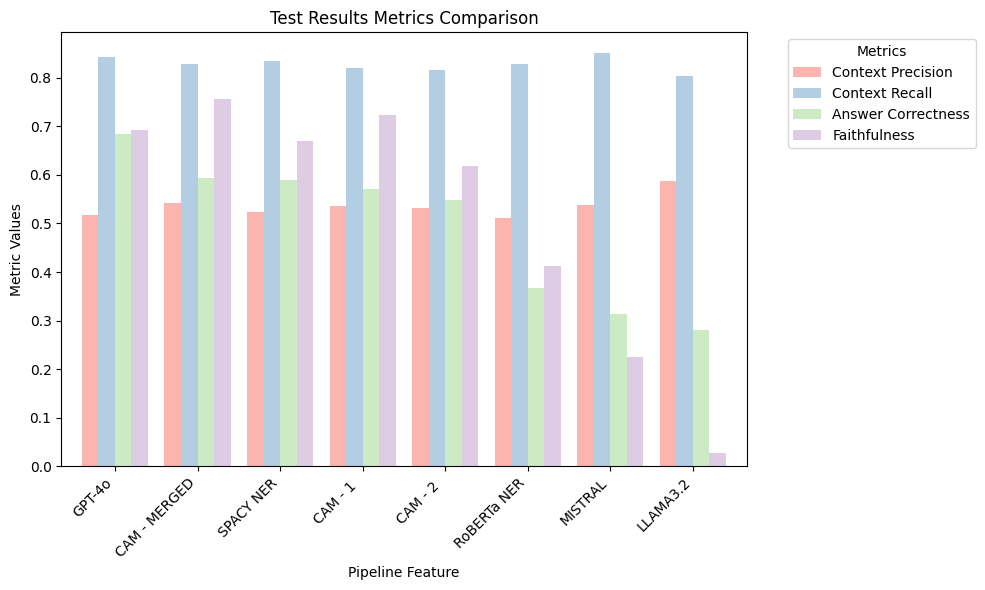

In [209]:
ax = aggregated_data.plot(kind='bar', figsize=(10, 6), width=0.8, color=plt.cm.Pastel1.colors)
ax.set_title('Test Results Metrics Comparison')
ax.set_xlabel('Pipeline Feature')
ax.set_ylabel('Metric Values')
ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()